In [11]:
from pytube import YouTube
import requests
from bs4 import BeautifulSoup as bs
from selenium import webdriver
import time
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
import numpy as np
import wave
import pandas as pd
import os
import pickle

In [2]:
driver = webdriver.Chrome
base = 'https://www.youtube.com/results?search_query='
qstring = '+motorcycle+exhaust+sound'
video_dict={}
make_list=['harley+davidson',
           'kawasaki']

driver = webdriver.Chrome()

for make in make_list:
    url = base+make+qstring
    driver.get(url);
    page = driver.get(url)
    for i in range(4):
    #Scroll
        driver.execute_script(
            "window.scrollTo(0, document.documentElement.scrollHeight);"
        )
    
        #Wait for page to load, shorter does not work
        time.sleep(5)
    soup=bs(driver.page_source,'html.parser')
    videolist=[]
    for video in soup.find_all('a', id='video-title'):
        tmp = 'https://youtube.com' + video.get("href")
        videolist.append(tmp)
    video_dict[make]=videolist.copy()

In [3]:
len(video_dict['harley+davidson'])

101

In [4]:
len(video_dict['kawasaki'])

100

In [5]:
for make in make_list:
    for i,url in enumerate(video_dict[make][-15::1]):
        print(make,i)
        print(url)
        print(type(url))
        try:
            video = YouTube(url)
            video.streams.filter(only_audio=True,mime_type='audio/mp4').order_by('abr').desc().first().download(
            output_path = 'test_audio'+'/'+make, filename=str(i))
        except:
            print('^This one is not working')
            continue

harley+davidson 0
https://youtube.com/watch?v=zOhuBtzHdkk
<class 'str'>
harley+davidson 1
https://youtube.com/watch?v=uGVuvQamhQc
<class 'str'>
harley+davidson 2
https://youtube.com/watch?v=-kdRRMlXLoU
<class 'str'>
harley+davidson 3
https://youtube.com/watch?v=0mOtOhnjRp4
<class 'str'>
harley+davidson 4
https://youtube.com/watch?v=eEOxQB_8pzA
<class 'str'>
harley+davidson 5
https://youtube.com/watch?v=KSaIS6Jgmi8
<class 'str'>
harley+davidson 6
https://youtube.com/watch?v=DowdWgFRqYo
<class 'str'>
harley+davidson 7
https://youtube.com/watch?v=JQ5-_csVoLA
<class 'str'>
harley+davidson 8
https://youtube.com/watch?v=f2yWXnFwUNw
<class 'str'>
harley+davidson 9
https://youtube.com/watch?v=68MUqFWoMDY
<class 'str'>
harley+davidson 10
https://youtube.com/watch?v=43QIUOtepxw
<class 'str'>
harley+davidson 11
https://youtube.com/watch?v=U34kpbVfkOk
<class 'str'>
harley+davidson 12
https://youtube.com/watch?v=Rx52b3ZiQ_k
<class 'str'>
harley+davidson 13
https://youtube.com/watch?v=UxDcYzgFY-g
<c

In [6]:
def chunk_audio_fft(audio_array,sample_rate,chunk_duration):
    chunked_df = pd.DataFrame()
    num_samples = int(chunk_duration*sample_rate)
    num_chunks = int(len(audio_array)//num_samples)
    for i in range (0,num_chunks,1):
        start_point=i*num_samples
        end_point=(i+1)*num_samples
        chunked_df[i] = fft_normalizer(fft_for_audio(audio_array[start_point:end_point],sample_rate))
    return chunked_df.transpose()

In [7]:
def fft_for_audio(array_in,sample_rate):
    fft_array = np.fft.fft(array_in)/len(array_in)
    fft_array = fft_array[range(int(len(array_in)/2))]
    frequencies = [i*sample_rate/len(array_in) for i in range(len(fft_array))][1:]
    return pd.Series(abs(fft_array[1:]), index = frequencies)

In [8]:
def fft_normalizer(fft_in):
    fft_out = fft_in.copy()
    fft_out.index=np.log2(fft_out.index)
    peaks=fft_out.copy()
    fundamental_freq = 0
    fundamental_peak = 0
    for freq in peaks.index:
        if peaks[freq] > ((freq-fundamental_freq)*2+1)*fundamental_peak:
            fundamental_peak = peaks[freq]
            fundamental_freq = freq
    fft_out.index=fft_out.index-fundamental_freq
    new_index=np.linspace(-5,4,num=451)
    resampling_dict = {}
    
    for freq in new_index:
        resampling_dict[freq] = [0,0]
    for freq in fft_out[fft_out.index < new_index.max()].index:
        new_freq = min(new_index, key=lambda x:abs(x-freq))
        resampling_dict[new_freq][0]+=fft_out[freq]
        resampling_dict[new_freq][1]+=1
    for freq in new_index:
        if resampling_dict[freq][1] == 0:
            resampling_dict[freq][1] = 1
    normalized=pd.Series([resampling_dict[freq][0]/resampling_dict[freq][1] for freq in new_index], index=new_index)
    scale = 1/normalized.max()
    return normalized*scale

In [29]:
total_df=pd.DataFrame()
directory_list = [dirname for dirpath, dirname, files in os.walk('./test_audio')][0]
for directory_name in directory_list:
    make_df=pd.DataFrame()
    file_list = [files for dirpath, dirname, files in os.walk('./test_audio/'+directory_name)][0]
    for file_name in file_list:
        try:
            command = 'rm ./tmp.wav'
            os.system(command)
            command = 'ffmpeg -i ./test_audio/'+directory_name+'/'+file_name+' -ac 1 ./tmp.wav'
            print(command)
            os.system(command)
            # Read file to get buffer                                                                                               
            ifile = wave.open('tmp.wav')
            samples = ifile.getnframes()
            sample_rate = ifile.getframerate()
            audio = ifile.readframes(samples)

            # Convert buffer to float32 using NumPy
            audio_as_np_int16 = np.frombuffer(audio, dtype=np.int16)
            audio_as_np_float32 = audio_as_np_int16.astype(np.float32)

            # Normalize float32 array so that values are between -1.0 and +1.0                                                      
            max_int16 = 2**15
            audio_normalized = audio_as_np_float32 / max_int16
        
            #Chunk the data into 1 second samples and get normalized FFTs thereof
            chunked_df = chunk_audio_fft(audio_normalized,sample_rate,1)
            chunked_df['file']=file_name
            make_df = pd.concat([make_df,chunked_df],ignore_index=True)
            with open('progress.pickle', 'wb') as to_write:
                pickle.dump(make_df, to_write)
            to_write.close()
        except:
            print('^This one is not working.')
            continue
    make_df['make'] = directory_name
    total_df = pd.concat([total_df,make_df],ignore_index=True)
    with open('test_motorcycles.pickle', 'wb') as to_write:
        pickle.dump(total_df, to_write)
    to_write.close()


ffmpeg -i ./test_audio/kawasaki/10.mp3 -ac 1 ./tmp.wav
ffmpeg -i ./test_audio/kawasaki/8.mp4 -ac 1 ./tmp.wav
ffmpeg -i ./test_audio/kawasaki/14.mp3 -ac 1 ./tmp.wav
ffmpeg -i ./test_audio/kawasaki/1.mp4 -ac 1 ./tmp.wav
ffmpeg -i ./test_audio/kawasaki/4.mp3 -ac 1 ./tmp.wav
ffmpeg -i ./test_audio/kawasaki/5.mp4 -ac 1 ./tmp.wav
ffmpeg -i ./test_audio/kawasaki/6.mp3 -ac 1 ./tmp.wav
ffmpeg -i ./test_audio/kawasaki/11.mp3 -ac 1 ./tmp.wav
ffmpeg -i ./test_audio/kawasaki/9.mp3 -ac 1 ./tmp.wav
ffmpeg -i ./test_audio/kawasaki/3.mp3 -ac 1 ./tmp.wav


<ipython-input-8-934aa5a64896>:25: RuntimeWarning: divide by zero encountered in double_scalars
  scale = 1/normalized.max()


ffmpeg -i ./test_audio/kawasaki/12.mp3 -ac 1 ./tmp.wav
ffmpeg -i ./test_audio/kawasaki/0.mp3 -ac 1 ./tmp.wav
ffmpeg -i ./test_audio/kawasaki/7.mp3 -ac 1 ./tmp.wav
ffmpeg -i ./test_audio/harley+davidson/10.mp3 -ac 1 ./tmp.wav
ffmpeg -i ./test_audio/harley+davidson/5.mp3 -ac 1 ./tmp.wav
ffmpeg -i ./test_audio/harley+davidson/9.mp4 -ac 1 ./tmp.wav
ffmpeg -i ./test_audio/harley+davidson/14.mp3 -ac 1 ./tmp.wav
ffmpeg -i ./test_audio/harley+davidson/11.mp4 -ac 1 ./tmp.wav
ffmpeg -i ./test_audio/harley+davidson/4.mp3 -ac 1 ./tmp.wav
ffmpeg -i ./test_audio/harley+davidson/6.mp3 -ac 1 ./tmp.wav
ffmpeg -i ./test_audio/harley+davidson/1.mp3 -ac 1 ./tmp.wav
ffmpeg -i ./test_audio/harley+davidson/3.mp3 -ac 1 ./tmp.wav
ffmpeg -i ./test_audio/harley+davidson/13.mp4 -ac 1 ./tmp.wav
ffmpeg -i ./test_audio/harley+davidson/12.mp3 -ac 1 ./tmp.wav
ffmpeg -i ./test_audio/harley+davidson/0.mp3 -ac 1 ./tmp.wav
ffmpeg -i ./test_audio/harley+davidson/7.mp3 -ac 1 ./tmp.wav


In [10]:
def chunk_audio_plain(audio_array,sample_rate,chunk_duration):
    chunked_df = pd.DataFrame()
    num_samples = int(chunk_duration*sample_rate)
    num_chunks = int(len(audio_array)//num_samples)
    for i in range (0,num_chunks,1):
        start_point=i*num_samples
        end_point=(i+1)*num_samples
        chunked_df[i] = audio_array[start_point:end_point]
    return chunked_df.transpose()

In [ ]:
total_df=pd.DataFrame()
directory_list = [dirname for dirpath, dirname, files in os.walk('./test_audio')][0]
for directory_name in directory_list:
    make_df=pd.DataFrame()
    file_list = [files for dirpath, dirname, files in os.walk('./test_audio/'+directory_name)][0]
    for file_name in file_list[0:4]:
        try:
            command = 'rm ./tmp.wav'
            os.system(command)
            command = 'ffmpeg -i ./test_audio/'+directory_name+'/'+file_name+' -ac 1 ./tmp.wav'
            print(command)
            os.system(command)
            # Read file to get buffer                                                                                               
            ifile = wave.open('tmp.wav')
            samples = ifile.getnframes()
            sample_rate = ifile.getframerate()
            audio = ifile.readframes(samples)

            # Convert buffer to float32 using NumPy
            audio_as_np_int16 = np.frombuffer(audio, dtype=np.int16)
            audio_as_np_float32 = audio_as_np_int16.astype(np.float32)

            # Normalize float32 array so that values are between -1.0 and +1.0                                                      
            max_int16 = 2**15
            audio_normalized = audio_as_np_float32 / max_int16
        
            #Chunk the data into 1 second samples and get normalized FFTs thereof
            chunked_df = chunk_audio_plain(audio_normalized,sample_rate,1)
            chunked_df['file']=file_name
            make_df = pd.concat([make_df,chunked_df],ignore_index=True)
        except:
            print('^This one is not working.')
            continue
    make_df['make'] = directory_name
    total_df = pd.concat([total_df,make_df],ignore_index=True)
    
with open('plain_sound.pickle', 'wb') as to_write:
        pickle.dump(total_df, to_write)
to_write.close()

<ipython-input-27-51609682ba37>:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax=plt.axes()


(array([-0.03, -0.02, -0.01,  0.  ,  0.01,  0.02,  0.03]),
 <a list of 7 Text major ticklabel objects>)

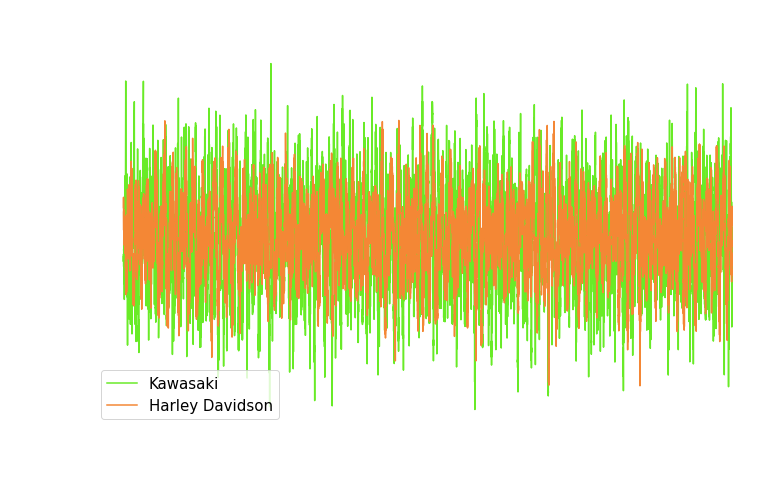

In [27]:
import matplotlib.pyplot as plt
total_df.groupby('make').mean()
fig = plt.gcf()
fig.set_size_inches(12, 7)
plt.plot(total_df.groupby('make').mean().loc['kawasaki',:],color='#69eb27',label='Kawasaki')
plt.plot(total_df.groupby('make').mean().loc['harley+davidson',:], color= '#f48735',label='Harley Davidson')
plt.xlabel("Time (Seconds/441000)",fontsize=30,color='white')
plt.ylabel('Amplitude',fontsize=30,color='white')
plt.title('Averaged Raw 1 Second Samples',fontsize=40,color='white')
plt.legend(fontsize=15)
ax=plt.axes()
ax.set_facecolor('#00000000')
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['left'].set_color('white')
ax.spines['right'].set_color('white')
ax.tick_params(axis='x', colors="white")
ax.tick_params(axis='y', colors="white")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)